In [3]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#print('matplotlib version=',matplotlib.__version__)
import matplotlib.ticker as ticker
# http://matplotlib.sourceforge.net/faq/howto_faq.html#multiple-y-axis-scales
import sys
print('sys version=',sys.version)
# ----------------------------------------
def ticks_cn2c(CN):
    #V = 1/(1+X)
    C = CN*12
    return ["%.0f" % c for c in C]
# ----------------------------------------

print('done')

sys version= 3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]
done


# Strong scaling results

In [6]:
# --- input data:
app='lammps' ;testcase='water_collapse'
if app=='lammps' and testcase=='water_collapse': 
    titlejg='LAMMPS/16Jul2018-CrayGNU-18.07-cuda-9.1\n(water_collapse, 9702 water particles, 40000 steps)'
    pdfjg='lammps_water'
    cores = [1,2,4,8,12,24,48,96]
    daintgpu_sec = [317.506,194.920,130.784,84.7541,68.3856,47.2624,32.8842,27.5419] # list
    nsteps=40000
    daintgpu_secperstep = [tt/nsteps for tt in daintgpu_sec] # list                                        
    #mn4_sec = [None,None,11.9, 5.9, 4.2, 2.8, 3.1]
print('daint_sec=',daintgpu_sec)
print('daint_secperstep=',daintgpu_secperstep)

daint_sec= [317.506, 194.92, 130.784, 84.7541, 68.3856, 47.2624, 32.8842, 27.5419]
daint_secperstep= [0.00793765, 0.004873, 0.0032695999999999997, 0.0021188525, 0.00170964, 0.00118156, 0.000822105, 0.0006885474999999999]


LAMMPS/16Jul2018-CrayGNU-18.07-cuda-9.1
(water_collapse, 9702 water particles, 40000 steps)


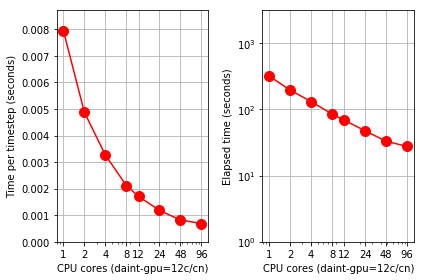

In [7]:
# --- setup figure:
# Turn interactive plotting off
# https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
plt.ioff()
plt.clf()

# CREATE MULTI-PLOT FIGURE
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False)
ax1.plot(cores, daintgpu_secperstep, 'ro-', label='', markersize=10)
ax2.plot(cores, daintgpu_sec, 'ro-', label='', markersize=10)


# --------------------------------------------------
ax1.grid(True)
ax1.set_xscale('log')
ax1.set_yscale('linear')
ax1.set_xlabel(r"CPU cores (daint-gpu=12c/cn)")
ax1.set_ylabel('Time per timestep (seconds)')
ax1.xaxis.set_major_locator(ticker.FixedLocator( np.array(cores) )) # ticks x1
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.set_ylim([0,1.1*max(daintgpu_secperstep)])

# --------------------------------------------------
ax2.grid(True)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r"CPU cores (daint-gpu=12c/cn)")
ax2.set_ylabel('Elapsed time (seconds)')
ax2.xaxis.set_major_locator(ticker.FixedLocator( np.array(cores) )) # ticks x1
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.set_ylim([1,10*max(daintgpu_sec)])

# --------------------------------------------------
plt.tick_params(
    axis='y',        # changes apply to the x-axis
    which='minor',   # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    right=False,     # ticks along the right edge are off
    labelleft=False  # labels along the left edge are off
) 


#### plt.savefig(fname='./2018/'+pdfjg+'.pdf')
print(titlejg)
plt.tight_layout()
# RESCALE PLOTS
default_figsize = plt.rcParamsDefault['figure.figsize']
plt.rcParams['figure.figsize'] = [4*val for val in default_figsize]
plt.show()

# Speedup and Parallel Efficiency

In [8]:
# http://www.vi-hps.org/upload/material/alechile12/vi-hps-alechile12-Intro_PerfAnal.pdf

# lists:
def ideal_speedup(inlist):
# ideal_speedup = cnn / cn1
    outlist = [] # list
    cn1 = inlist[0] # [0]
    for ccc in inlist:
        outlist.append(ccc)
    return outlist

def speedup(inlist):
# speedup = t1 / tn
    outlist = [] # list
    t1 = inlist[0]
    for tt in inlist:
        outlist.append(t1/tt)
    return outlist

def parallel_efficiency(inlistS, inlistC):
# parallel_efficiency = speedupn / cnn
    outlist = [] # list
    nn = 0
    for ss in inlistS:        
        outlist.append(ss / inlistC[nn] * 100)
        nn += 1
    return outlist

In [9]:
# from IPython.display import display, Markdown
# display(Markdown('*some markdown* $\phi$'))
# https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output
import io
from IPython.core.display import HTML
def html_table(np, tt, ss, iss, peff):
    strjg = '<table><thead><tr> <th>np</th> <th>mpi tasks</th> <th>seconds</th> <th>measured speedup</th> <th>ideal speedup</th> <th>// efficiency</th> </tr></thead>'
    strjg += '<tbody>'

    bufjg = io.StringIO()
    nnn=0
    for vv in peff:
        print("<tr> <th>{0}</th> <td>{1:02d}</td> <td> {2:8.2f}</td> <td> {3:5.1f}</td> <td>{4:03.0f}</td> <td> {5:03.0f}%</td> </tr>"
          .format(np, cores[nnn] ,tt[nnn] ,ss[nnn], iss[nnn] ,vv), file=bufjg )    
        nnn=nnn+1

    strjg += bufjg.getvalue()    
    bufjg.close()
    strjg += '</tbody></table>'
    #print('strjg=',strjg)
    #HTML(strjg)
    return strjg

print('ok')

ok


In [10]:
npart=15702
isp=ideal_speedup(cores)
sp=speedup(daintgpu_sec)
peff=parallel_efficiency(sp,cores)
#print(isp,sp,peff)
HTML( html_table(npart, daintgpu_sec, sp, isp, peff) )
#no!!! print('after')

np,mpi tasks,seconds,measured speedup,ideal speedup,// efficiency
15702,01,317.51,1.0,001,100%
15702,02,194.92,1.6,002,081%
15702,04,130.78,2.4,004,061%
15702,08,84.75,3.7,008,047%
15702,12,68.39,4.6,012,039%
15702,24,47.26,6.7,024,028%
15702,48,32.88,9.7,048,020%
15702,96,27.54,11.5,096,012%


LAMMPS/16Jul2018-CrayGNU-18.07-cuda-9.1
(water_collapse, 9702 water particles, 40000 steps)


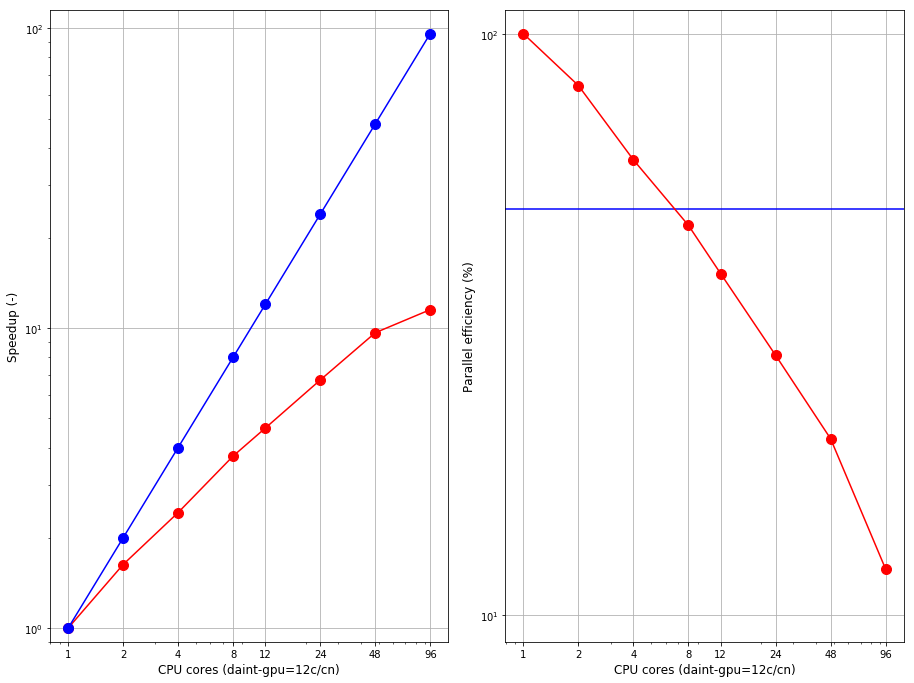

In [12]:
# --- setup figure:
# Turn interactive plotting off
# https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
plt.ioff()
plt.clf()

# CREATE MULTI-PLOT FIGURE
f, (ax, ax1) = plt.subplots(1, 2, sharey = False)
ax.plot(cores, speedup(daintgpu_sec), 'ro-', label='', markersize=10)
ax.plot(cores, ideal_speedup(cores), 'bo-', label='', markersize=10)
ax1.axhline(y=50, color='b', linestyle='-')
ax1.plot(cores, peff, 'ro-', label='', markersize=10)

# --------------------------------------------------
ax.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"CPU cores (daint-gpu=12c/cn)", fontsize=12)
ax.set_ylabel('Speedup (-)', fontsize=12)
ax.xaxis.set_major_locator(ticker.FixedLocator( np.array(cores) )) # ticks x1
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylim([0.9,10*max(speedup(daintgpu_sec))])

ax1.grid(True)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"CPU cores (daint-gpu=12c/cn)", fontsize=12)
ax1.set_ylabel('Parallel efficiency (%)', fontsize=12)
ax1.xaxis.set_major_locator(ticker.FixedLocator( np.array(cores) )) # ticks x1
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.set_ylim([9,1.1*max(peff)])

# --------------------------------------------------
plt.tick_params(
    axis='y',        # changes apply to the x-axis
    which='minor',   # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    right=False,     # ticks along the right edge are off
    labelleft=False  # labels along the left edge are off
) 


#### plt.savefig(fname='./2018/'+pdfjg+'.pdf')
print(titlejg)
plt.tight_layout()
# RESCALE PLOTS
default_figsize = plt.rcParamsDefault['figure.figsize']
plt.rcParams['figure.figsize'] = [2*val for val in default_figsize]
plt.show()